In [ ]:
!pip3 install librosa

In [90]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate, get_audio_info

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [91]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [92]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

In [93]:
df = pd.DataFrame(raw)
# df = df[:100]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [94]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [95]:
# get sample rate and clip duration for every clip
df_train[['sr','duration']] = df_train['path'].apply(lambda p: get_audio_info(p))
df_test[['sr','duration']] = df_test['path'].apply(lambda p: get_audio_info(p))

df_train.head()

,speaker,path,sr,duration
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062


In [96]:
print(f'{df_train.describe()} \n {df_test.describe()}')

            sr     duration
count   1950.0  1950.000000
mean   16000.0     7.688083
std        0.0     4.507359
min    16000.0     3.960062
25%    16000.0     4.840063
50%    16000.0     6.240062
75%    16000.0     8.960062
max    16000.0    61.680062 
             sr    duration
count    837.0  837.000000
mean   16000.0    7.755045
std        0.0    4.491689
min    16000.0    3.960062
25%    16000.0    4.880063
50%    16000.0    6.360062
75%    16000.0    8.920063
max    16000.0   37.280062


In [97]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [98]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [99]:
df_train.head()

,speaker,path,sr,duration,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [100]:
df_test.head()

,speaker,path,sr,duration,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [101]:
# a = df_test.iloc[26,5]
# plt.plot(a)
# plt.show()
# print(a.mean())

In [102]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,4:7]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (1365, 39), Validation set size (585, 39)


## Deep Learning Model

In [112]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4000      
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_9 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)              

In [113]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 16


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
86/86 [==============================] - 1s 5ms/step - loss: 15.2565 - accuracy: 0.0901 - val_loss: 2.9700 - val_accuracy: 0.0462

Epoch 00001: val_loss improved from inf to 2.97004, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
86/86 [==============================] - 0s 4ms/step - loss: 3.8514 - accuracy: 0.0989 - val_loss: 2.9725 - val_accuracy: 0.2188

Epoch 00002: val_loss did not improve from 2.97004
Epoch 3/200
86/86 [==============================] - 0s 5ms/step - loss: 3.1091 - accuracy: 0.1326 - val_loss: 2.9503 - val_accuracy: 0.2188

Epoch 00003: val_loss improved from 2.97004 to 2.95033, saving model to saved_models/speakers_classification.hdf5
Epoch 4/200
86/86 [==============================] - 0s 4ms/step - loss: 2.9945 - accuracy: 0.1678 - val_loss: 2.9290 - val_accuracy: 0.2188

Epoch 00004: val_loss improved from 2.95033 to 2.92900, saving model to saved_models/speakers_classification.hdf5
Epoch 5/200
86/86 [=======================


Epoch 00034: val_loss improved from 2.08213 to 2.05296, saving model to saved_models/speakers_classification.hdf5
Epoch 35/200
86/86 [==============================] - 0s 3ms/step - loss: 2.1519 - accuracy: 0.3319 - val_loss: 2.0097 - val_accuracy: 0.3949

Epoch 00035: val_loss improved from 2.05296 to 2.00969, saving model to saved_models/speakers_classification.hdf5
Epoch 36/200
86/86 [==============================] - 0s 3ms/step - loss: 2.1397 - accuracy: 0.3348 - val_loss: 1.9890 - val_accuracy: 0.3641

Epoch 00036: val_loss improved from 2.00969 to 1.98897, saving model to saved_models/speakers_classification.hdf5
Epoch 37/200
86/86 [==============================] - 0s 3ms/step - loss: 2.0633 - accuracy: 0.3524 - val_loss: 1.9398 - val_accuracy: 0.4017

Epoch 00037: val_loss improved from 1.98897 to 1.93978, saving model to saved_models/speakers_classification.hdf5
Epoch 38/200
86/86 [==============================] - 0s 3ms/step - loss: 2.0801 - accuracy: 0.3568 - val_loss: 1.

Epoch 69/200
86/86 [==============================] - 0s 3ms/step - loss: 1.0668 - accuracy: 0.6696 - val_loss: 1.0113 - val_accuracy: 0.6632

Epoch 00069: val_loss did not improve from 0.96875
Epoch 70/200
86/86 [==============================] - 0s 3ms/step - loss: 1.0293 - accuracy: 0.6777 - val_loss: 0.9309 - val_accuracy: 0.7060

Epoch 00070: val_loss improved from 0.96875 to 0.93091, saving model to saved_models/speakers_classification.hdf5
Epoch 71/200
86/86 [==============================] - 0s 5ms/step - loss: 1.1041 - accuracy: 0.6418 - val_loss: 0.9473 - val_accuracy: 0.6889

Epoch 00071: val_loss did not improve from 0.93091
Epoch 72/200
86/86 [==============================] - 0s 3ms/step - loss: 1.0409 - accuracy: 0.6733 - val_loss: 0.9250 - val_accuracy: 0.6872

Epoch 00072: val_loss improved from 0.93091 to 0.92501, saving model to saved_models/speakers_classification.hdf5
Epoch 73/200
86/86 [==============================] - 0s 4ms/step - loss: 1.0155 - accuracy: 0.676

86/86 [==============================] - 1s 10ms/step - loss: 0.7796 - accuracy: 0.7465 - val_loss: 0.7978 - val_accuracy: 0.7453

Epoch 00105: val_loss did not improve from 0.71805
Epoch 106/200
86/86 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.7692 - val_loss: 0.7350 - val_accuracy: 0.7761

Epoch 00106: val_loss did not improve from 0.71805
Epoch 107/200
86/86 [==============================] - 0s 4ms/step - loss: 0.7044 - accuracy: 0.7729 - val_loss: 0.7245 - val_accuracy: 0.7761

Epoch 00107: val_loss did not improve from 0.71805
Epoch 108/200
86/86 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.7729 - val_loss: 0.7242 - val_accuracy: 0.7761

Epoch 00108: val_loss did not improve from 0.71805
Epoch 109/200
86/86 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.7714 - val_loss: 0.7053 - val_accuracy: 0.7709

Epoch 00109: val_loss improved from 0.71805 to 0.70535, saving model to saved_models/spea

86/86 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.8000 - val_loss: 0.6946 - val_accuracy: 0.7983

Epoch 00145: val_loss did not improve from 0.63672
Epoch 146/200
86/86 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.8198 - val_loss: 0.6918 - val_accuracy: 0.7949

Epoch 00146: val_loss did not improve from 0.63672
Epoch 147/200
86/86 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.8000 - val_loss: 0.6884 - val_accuracy: 0.7915

Epoch 00147: val_loss did not improve from 0.63672
Epoch 148/200
86/86 [==============================] - 0s 3ms/step - loss: 0.5776 - accuracy: 0.8234 - val_loss: 0.7142 - val_accuracy: 0.7761

Epoch 00148: val_loss did not improve from 0.63672
Epoch 149/200
86/86 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.8059 - val_loss: 0.6723 - val_accuracy: 0.7932

Epoch 00149: val_loss did not improve from 0.63672
Epoch 150/200
86/86 [==================

86/86 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.8469 - val_loss: 0.7015 - val_accuracy: 0.7812

Epoch 00187: val_loss did not improve from 0.63672
Epoch 188/200
86/86 [==============================] - 0s 3ms/step - loss: 0.5145 - accuracy: 0.8271 - val_loss: 0.6719 - val_accuracy: 0.8051

Epoch 00188: val_loss did not improve from 0.63672
Epoch 189/200
86/86 [==============================] - 0s 4ms/step - loss: 0.4779 - accuracy: 0.8491 - val_loss: 0.6583 - val_accuracy: 0.7915

Epoch 00189: val_loss did not improve from 0.63672
Epoch 190/200
86/86 [==============================] - 0s 4ms/step - loss: 0.5312 - accuracy: 0.8271 - val_loss: 0.6523 - val_accuracy: 0.8085

Epoch 00190: val_loss did not improve from 0.63672
Epoch 191/200
86/86 [==============================] - 0s 3ms/step - loss: 0.5111 - accuracy: 0.8308 - val_loss: 0.6451 - val_accuracy: 0.7983

Epoch 00191: val_loss did not improve from 0.63672
Epoch 192/200
86/86 [==================

### Check training history

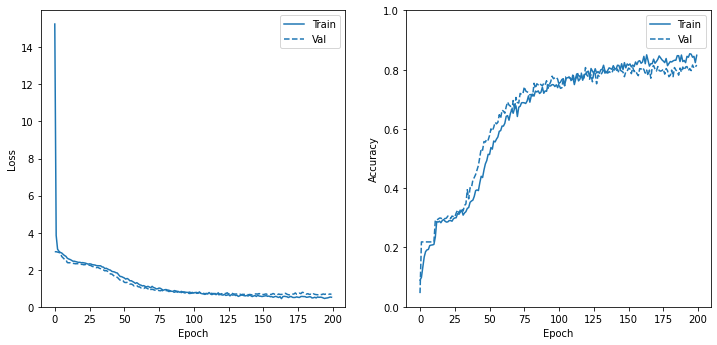

In [114]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [115]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(837, 39)
['id10003' 'id10009' 'id10009' 'id10003' 'id10009' 'id10009' 'id10009'
 'id10016' 'id10009' 'id10016' 'id10004' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10009' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10001' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10014' 'id10007'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10004' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10014' 'id10006'
 'id10004' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10014' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10001' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10001' 'id10001' 'id10001' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10006' 'id10001' 'id10017' 'id10001' 'id10001' 'id100

## Gausian Mixture Model

In [107]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
# for every speaker fit a GMM and save the model
unique_speakers = df_train['speaker'].unique()
for speaker in unique_speakers:
    df_speaker = df_train[df_train['speaker'] == speaker]
    features = np.asarray(())
    for index, row in df_speaker.iterrows():
        vector = np.hstack((row['mfcc'], row['delta'], row['zcr']))
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features,vector))
    
    gmm = mixture.GaussianMixture(n_components = 16, covariance_type='diag',n_init = 3)
    gmm.fit(features)    
    filename = 'saved_models/gmm/' + f'gmm_{speaker}.sav'
    pickle.dump(gmm, open(filename, 'wb'))
        


In [111]:
# load models and predict on test
gmm_files = [os.path.join('saved_models/gmm/',fname) for fname in 
              os.listdir('saved_models/gmm/') if fname.endswith('.sav')]

#Load the Gaussian gender Models
gmm_models = [pickle.load(open(fname,'rb')) for fname in gmm_files]
unique_speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
              in gmm_files]

print(unique_speakers)
nr_errors = 0
total_samples = len(df_test)
for index, row in df_test.iterrows():
    log_likelihood = np.zeros(len(gmm_models)) 
    features = np.hstack((row['mfcc'], row['delta'], row['zcr']))
    features = features.reshape(1,-1)
    
    for i, gmm in enumerate(gmm_models):
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()

    y_pred = np.argmax(log_likelihood)
    if unique_speakers[y_pred] != 'gmm_' + row['speaker']+ '.sav':
        nr_errors += 1

accuracy = ((total_samples - nr_errors) / total_samples) * 100
print (f'The Accuracy with (MFCC + DELTA + ZCR) and GMM is : {accuracy}')


['gmm_id10020.sav', 'gmm_id10008.sav', 'gmm_id10009.sav', 'gmm_id10019.sav', 'gmm_id10018.sav', 'gmm_id10016.sav', 'gmm_id10002.sav', 'gmm_id10003.sav', 'gmm_id10017.sav', 'gmm_id10001.sav', 'gmm_id10015.sav', 'gmm_id10014.sav', 'gmm_id10004.sav', 'gmm_id10010.sav', 'gmm_id10011.sav', 'gmm_id10005.sav', 'gmm_id10013.sav', 'gmm_id10007.sav', 'gmm_id10006.sav', 'gmm_id10012.sav']
The Accuracy with (MFCC + DELTA + ZCR) and GMM is : 99.4026284348865
